In [1]:
from train import *
from processing import find_estado_with_value_two
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np
import pandas as pd
import xgboost as xgb
import random
import shap
pd.set_option('display.max_columns', None)
random.seed(10)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Baseline Model

In [2]:
df = build_dataset_with_features(categorical_features= False,climate_features=False)
train, val, test = train_test_val_split(df)

In [3]:
x_train, y_train = split_into_x_y(train)
x_test, y_test = split_into_x_y(test)
x_val, y_val = split_into_x_y(val)

In [4]:
metrics_dictionary = {}
def get_metrics_train_val(model, name, print_metrics=True):
    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)
    
    train_mse = round(mean_squared_error(y_train, y_pred_train), 2)
    val_mse = round(mean_squared_error(y_val, y_pred_val), 2)
    val_mse_discrete = round(mse_score_discrete(y_val, y_pred_val), 2)

    if print_metrics:
        print('Train MSE {}: {}'.format(name, train_mse))
        print('Validation MSE {}: {}'.format(name, val_mse))
        print('Validation MSE Discrete {}: {}'.format(name, val_mse_discrete))
    
    metrics_dictionary[name] = [train_mse, val_mse, val_mse_discrete, model]

    return train_mse, val_mse, val_mse_discrete


In [5]:
baseline_train_pred = [0] * len(x_train)
baseline_val_pred = [0] * len(x_val)
print('Train MSE baseline: {}'.format(metrics.mean_squared_error(y_train, baseline_train_pred)))
print('Validation MSE baseline: {}'.format(metrics.mean_squared_error(y_val, baseline_val_pred)))
print('Validation MSE discrete baseline: {}'.format(mse_score_discrete(y_val, baseline_val_pred)))

Train MSE baseline: 1.1101813515880787
Validation MSE baseline: 1.063456548065279
Validation MSE discrete baseline: 1.063456548065279


### Models for non-categorical variables parcela

In [6]:
basic_reg_model = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', LinearRegression()) 
])

basic_reg_model.fit(x_train, y_train)

get_metrics_train_val(basic_reg_model, "Linear Regression")

coefficients = basic_reg_model.named_steps['regressor'].coef_

print("\n Coefficients:")
for feature, coef in zip(x_train.columns, coefficients):
    print(f"{feature}: {round(coef,4)}")

Train MSE Linear Regression: 0.34
Validation MSE Linear Regression: 0.33
Validation MSE Discrete Linear Regression: 0.42

 Coefficients:
104_altitud_(m): -0.001
201_superf_cultivada_en_la_parcela_agrícola_(ha): 0.0057
202_pendiente_(%): 0.0045
301_marco_(m_x_m): 0.0004
302_densidad_(plantas/ha): -0.0021
303_nº_pies_por_árbol: 0.0035
porcentaje_floracion: 0.0029
211_utilización_de_cubierta_vegetal: -0.003
208_riego:_procedencia_del_agua: -0.0028
207_riego:_sistema_usual_de_riego: 0.0016
109_sistema_para_el_cumplimiento_gestión_integrada: 0.0039
estado_fenologico_1: 0.0803
estado_fenologico_2: 0.0995
estado_fenologico_3: 0.204
estado_fenologico_4: 0.2554
estado_fenologico_5: 0.2067
estado_fenologico_6: 0.1842
estado_fenologico_7: 0.234
estado_fenologico_8: 0.0868
estado_fenologico_9: 0.0368
estado_fenologico_10: -0.0597
estado_fenologico_11: 0.1322
estado_fenologico_12: 0.0315
estado_fenologico_13: 0.0037
estado_fenologico_14: -0.0037
number_days_current_estado: 0.0876


In [7]:
def run_ridge_models():
    param_grid = [0.001, 0.01, 0.1, 1, 10, 100]
    
    for alpha in param_grid:
        reg_model = Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', Ridge(alpha=alpha))])

        reg_model.fit(x_train, y_train)
        
        get_metrics_train_val(reg_model, f"Ridge (alpha = {alpha})")

run_ridge_models()

Train MSE Ridge (alpha = 0.001): 0.34
Validation MSE Ridge (alpha = 0.001): 0.33
Validation MSE Discrete Ridge (alpha = 0.001): 0.42
Train MSE Ridge (alpha = 0.01): 0.34
Validation MSE Ridge (alpha = 0.01): 0.33
Validation MSE Discrete Ridge (alpha = 0.01): 0.42
Train MSE Ridge (alpha = 0.1): 0.34
Validation MSE Ridge (alpha = 0.1): 0.33
Validation MSE Discrete Ridge (alpha = 0.1): 0.42
Train MSE Ridge (alpha = 1): 0.34
Validation MSE Ridge (alpha = 1): 0.33
Validation MSE Discrete Ridge (alpha = 1): 0.42
Train MSE Ridge (alpha = 10): 0.34
Validation MSE Ridge (alpha = 10): 0.33
Validation MSE Discrete Ridge (alpha = 10): 0.42
Train MSE Ridge (alpha = 100): 0.34
Validation MSE Ridge (alpha = 100): 0.33
Validation MSE Discrete Ridge (alpha = 100): 0.42


In [8]:
def run_ridge_models():
    param_grid = [0.001, 0.01, 0.1, 1, 10, 100]
    
    for alpha in param_grid:
        reg_model = Pipeline([
        ('scaler', StandardScaler()), 
        ('regressor', Lasso(alpha=alpha))])

        reg_model.fit(x_train, y_train)
        
        get_metrics_train_val(reg_model, f"Ridge (alpha = {alpha})")

run_ridge_models()

Train MSE Ridge (alpha = 0.001): 0.34
Validation MSE Ridge (alpha = 0.001): 0.33
Validation MSE Discrete Ridge (alpha = 0.001): 0.42
Train MSE Ridge (alpha = 0.01): 0.34
Validation MSE Ridge (alpha = 0.01): 0.32
Validation MSE Discrete Ridge (alpha = 0.01): 0.42
Train MSE Ridge (alpha = 0.1): 0.4
Validation MSE Ridge (alpha = 0.1): 0.37
Validation MSE Discrete Ridge (alpha = 0.1): 0.51
Train MSE Ridge (alpha = 1): 0.67
Validation MSE Ridge (alpha = 1): 0.64
Validation MSE Discrete Ridge (alpha = 1): 0.76
Train MSE Ridge (alpha = 10): 0.67
Validation MSE Ridge (alpha = 10): 0.64
Validation MSE Discrete Ridge (alpha = 10): 0.76
Train MSE Ridge (alpha = 100): 0.67
Validation MSE Ridge (alpha = 100): 0.64
Validation MSE Discrete Ridge (alpha = 100): 0.76


In [9]:
n_trees_grid = [5,25,50]

for n_trees in n_trees_grid:
    rf = RandomForestRegressor(n_estimators=n_trees)
    rf.fit(x_train, y_train)
    get_metrics_train_val(rf,f"Random Forest Regressor (n_trees = {n_trees})")


Train MSE Random Forest Regressor (n_trees = 5): 0.14
Validation MSE Random Forest Regressor (n_trees = 5): 0.31
Validation MSE Discrete Random Forest Regressor (n_trees = 5): 0.37
Train MSE Random Forest Regressor (n_trees = 25): 0.13
Validation MSE Random Forest Regressor (n_trees = 25): 0.29
Validation MSE Discrete Random Forest Regressor (n_trees = 25): 0.35
Train MSE Random Forest Regressor (n_trees = 50): 0.13
Validation MSE Random Forest Regressor (n_trees = 50): 0.28
Validation MSE Discrete Random Forest Regressor (n_trees = 50): 0.34


In [10]:
learning_rates = [0.001, 0.01, 0.1, 1]
depths = [1, 5, 10]
n_trees = [5, 25, 50, 100]
best_score = np.inf

for lr in learning_rates:
    for depth in depths:
        for trees in n_trees:
            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lr, max_depth=depth, n_estimators=trees, random_state=1)
            xgb_model.fit(x_train, y_train)
            train_mse, val_mse, val_mse_discrete = get_metrics_train_val(xgb_model,f'Learning rate: {lr}, max_depth: {depth}, n_estimators: {trees}',print_metrics=False)
            if val_mse < best_score:
                best_scores = {'train_mse': train_mse,'val_mse': val_mse, 'val_mse_discrete': val_mse_discrete}
                best_params = {'learning_rate': lr,'max_depth': depth, 'n_trees': trees}

print(best_params)
print(best_scores)

{'learning_rate': 1, 'max_depth': 10, 'n_trees': 100}
{'train_mse': 0.15, 'val_mse': 0.35, 'val_mse_discrete': 0.4}


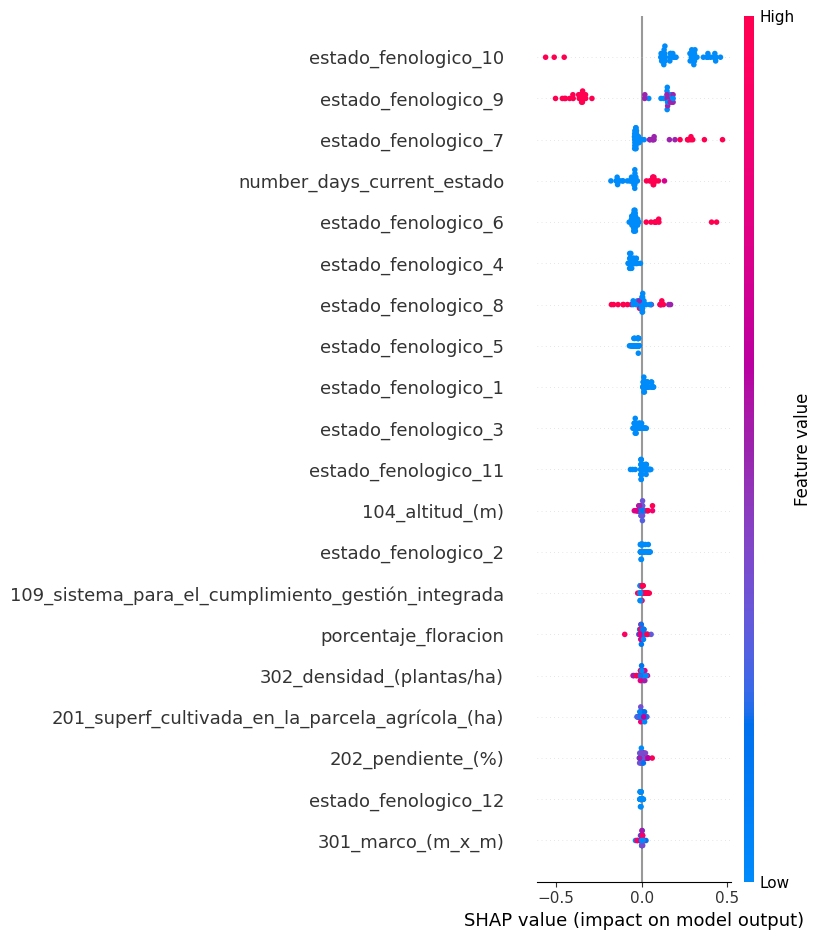

In [11]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(x_val[:50])
shap.summary_plot(shap_values, x_val[:50])

In [12]:
#Best predicitons of the model
y_pred = rf.predict(x_test)
y_pred_rounded = []

for pred in y_pred:
    if pred - int(pred) < 0.5:
        y_pred_rounded.append(max(0, math.floor(pred)))
    else:
        y_pred_rounded.append(max(0, math.ceil(pred)))

y_final = y_test - y_pred_rounded

print(y_final.value_counts())

next_y
 0    31650
-1     5706
 1     4514
-2      466
 2      232
 3       25
-3       13
 4        3
 5        2
 7        1
Name: count, dtype: int64


### Best Models Parcela With Categorical Features

In [13]:
df_all_parcelas = build_dataset_with_features(climate_features=False)

In [14]:
categorical_columns = [
        "campaña",
        "105_comarca",
        "203_orientación",
        "204_textura_del_suelo",
        "206_secano_/_regadío",
        "212_tipo_de_cubierta_vegetal",
        "304_formación",
        "308_variedad_principal",
        "120_zona_biológica_raif",
        "310_patrón_variedad_principal",
    ]
df_all_parcelas[categorical_columns] = df_all_parcelas[categorical_columns].astype("category")
df_encoded = pd.get_dummies(df_all_parcelas, columns=categorical_columns)

# Display the resulting DataFrame with one-hot encoding
train, val, test = train_test_val_split(df_encoded)
x_train, y_train = split_into_x_y(train)
x_test, y_test = split_into_x_y(test)
x_val, y_val = split_into_x_y(val)

for n_trees in n_trees_grid:
    rf = RandomForestRegressor(n_estimators=n_trees)
    rf.fit(x_train, y_train)
    get_metrics_train_val(rf,f"Random Forest All Variables Parcelas (n_trees = {n_trees})")
# df.drop()

Train MSE Random Forest All Variables Parcelas (n_trees = 5): 0.08
Validation MSE Random Forest All Variables Parcelas (n_trees = 5): 0.3
Validation MSE Discrete Random Forest All Variables Parcelas (n_trees = 5): 0.35
Train MSE Random Forest All Variables Parcelas (n_trees = 25): 0.07
Validation MSE Random Forest All Variables Parcelas (n_trees = 25): 0.27
Validation MSE Discrete Random Forest All Variables Parcelas (n_trees = 25): 0.32
Train MSE Random Forest All Variables Parcelas (n_trees = 50): 0.06
Validation MSE Random Forest All Variables Parcelas (n_trees = 50): 0.27
Validation MSE Discrete Random Forest All Variables Parcelas (n_trees = 50): 0.32


In [15]:
learning_rates = [0.1]
depths = [25, 50]
n_trees = [25, 50,]
best_score = np.inf

for lr in learning_rates:
    for depth in depths:
        for trees in n_trees:
            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lr, max_depth=depth, n_estimators=trees, random_state=1)
            xgb_model.fit(x_train, y_train)
            train_mse, val_mse, val_mse_discrete = get_metrics_train_val(xgb_model,f'All Parcelas: Learning rate: {lr}, max_depth: {depth}, n_estimators: {trees}',print_metrics=False)
            if val_mse < best_score:
                best_scores = {'train_mse': train_mse,'val_mse': val_mse, 'val_mse_discrete': val_mse_discrete}
                best_params = {'learning_rate': lr,'max_depth': depth, 'n_trees': trees}

print(best_params)
print(best_scores)

{'learning_rate': 0.1, 'max_depth': 50, 'n_trees': 50}
{'train_mse': 0.04, 'val_mse': 0.3, 'val_mse_discrete': 0.35}


In [16]:
print(best_params)
print(best_scores)

{'learning_rate': 0.1, 'max_depth': 50, 'n_trees': 50}
{'train_mse': 0.04, 'val_mse': 0.3, 'val_mse_discrete': 0.35}


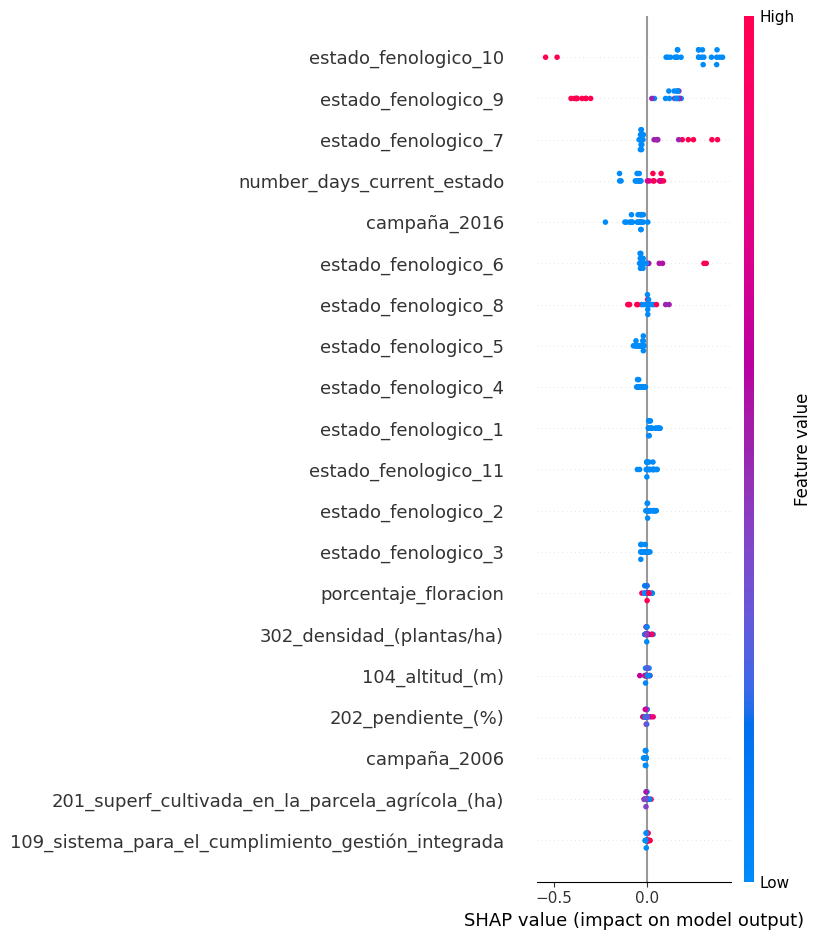

In [17]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(x_val[:25])
shap.summary_plot(shap_values, x_val[:25])

### Models Climatic + Parcelas

In [18]:
df_climatic = build_dataset_with_features(categorical_features=False)
df_climatic.dropna(subset="next_y", inplace=True)
climatic_vars = ['stl1_min_1',
 'stl1_max_1',
 'stl1_mean_1',
 'stl1_median_1',
 'stl1_std_1',
 'tp_min_1',
 'tp_max_1',
 'tp_mean_1',
 'tp_median_1',
 'tp_std_1',
 'swvl1_min_1',
 'swvl1_max_1',
 'swvl1_mean_1',
 'swvl1_median_1',
 'swvl1_std_1',
 'u10_min_1',
 'u10_max_1',
 'u10_mean_1',
 'u10_median_1',
 'u10_std_1',
 'v10_min_1',
 'v10_max_1',
 'v10_mean_1',
 'v10_median_1',
 'v10_std_1',
 'ssr_min_1',
 'ssr_max_1',
 'ssr_mean_1',
 'ssr_median_1',
 'ssr_std_1',
 'stl1_min_2',
 'stl1_max_2',
 'stl1_mean_2',
 'stl1_median_2',
 'stl1_std_2',
 'tp_min_2',
 'tp_max_2',
 'tp_mean_2',
 'tp_median_2',
 'tp_std_2',
 'swvl1_min_2',
 'swvl1_max_2',
 'swvl1_mean_2',
 'swvl1_median_2',
 'swvl1_std_2',
 'u10_min_2',
 'u10_max_2',
 'u10_mean_2',
 'u10_median_2',
 'u10_std_2',
 'v10_min_2',
 'v10_max_2',
 'v10_mean_2',
 'v10_median_2',
 'v10_std_2',
 'ssr_min_2',
 'ssr_max_2',
 'ssr_mean_2',
 'ssr_median_2',
 'ssr_std_2',
 'stl1_min_3',
 'stl1_max_3',
 'stl1_mean_3',
 'stl1_median_3',
 'stl1_std_3',
 'tp_min_3',
 'tp_max_3',
 'tp_mean_3',
 'tp_median_3',
 'tp_std_3',
 'swvl1_min_3',
 'swvl1_max_3',
 'swvl1_mean_3',
 'swvl1_median_3',
 'swvl1_std_3',
 'u10_min_3',
 'u10_max_3',
 'u10_mean_3',
 'u10_median_3',
 'u10_std_3',
 'v10_min_3',
 'v10_max_3',
 'v10_mean_3',
 'v10_median_3',
 'v10_std_3',
 'ssr_min_3',
 'ssr_max_3',
 'ssr_mean_3',
 'ssr_median_3',
 'ssr_std_3',
 'stl1_min_4',
 'stl1_max_4',
 'stl1_mean_4',
 'stl1_median_4',
 'stl1_std_4',
 'tp_min_4',
 'tp_max_4',
 'tp_mean_4',
 'tp_median_4',
 'tp_std_4',
 'swvl1_min_4',
 'swvl1_max_4',
 'swvl1_mean_4',
 'swvl1_median_4',
 'swvl1_std_4',
 'u10_min_4',
 'u10_max_4',
 'u10_mean_4',
 'u10_median_4',
 'u10_std_4',
 'v10_min_4',
 'v10_max_4',
 'v10_mean_4',
 'v10_median_4',
 'v10_std_4',
 'ssr_min_4',
 'ssr_max_4',
 'ssr_mean_4',
 'ssr_median_4',
 'ssr_std_4',
 'value_ndvi_min_1',
 'value_ndvi_max_1',
 'value_ndvi_mean_1',
 'value_ndvi_median_1',
 'value_ndvi_std_1',
 'value_fapar_min_1',
 'value_fapar_max_1',
 'value_fapar_mean_1',
 'value_fapar_median_1',
 'value_fapar_std_1']

df_climatic[climatic_vars] = df_climatic[climatic_vars].astype('float32')

train, val, test = train_test_val_split(df_climatic)
x_train, y_train = split_into_x_y(train)
x_test, y_test = split_into_x_y(test)
x_val, y_val = split_into_x_y(val)

In [19]:
n_trees_grid = [50]

for n_trees in n_trees_grid:
    rf = RandomForestRegressor(n_estimators=n_trees)
    rf.fit(x_train, y_train)
    get_metrics_train_val(rf,f"Random Forest Regressor Climatic (n_trees = {n_trees})")

Train MSE Random Forest Regressor Climatic (n_trees = 50): 0.02
Validation MSE Random Forest Regressor Climatic (n_trees = 50): 0.24
Validation MSE Discrete Random Forest Regressor Climatic (n_trees = 50): 0.3


In [20]:
learning_rates = [0.1]
depths = [25, 50]
n_trees = [25]
best_score = np.inf

for lr in learning_rates:
    for depth in depths:
        for trees in n_trees:
            xgb_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', learning_rate=lr, max_depth=depth, n_estimators=trees, random_state=1)
            xgb_model.fit(x_train, y_train)
            train_mse, val_mse, val_mse_discrete = get_metrics_train_val(xgb_model,f'Climatic: Learning rate: {lr}, max_depth: {depth}, n_estimators: {trees}',print_metrics=False)
            if val_mse < best_score:
                best_scores = {'train_mse': train_mse,'val_mse': val_mse, 'val_mse_discrete': val_mse_discrete}
                best_params = {'learning_rate': lr,'max_depth': depth, 'n_trees': trees}

print(best_params)
print(best_scores)

{'learning_rate': 0.1, 'max_depth': 50, 'n_trees': 25}
{'train_mse': 0.01, 'val_mse': 0.28, 'val_mse_discrete': 0.35}


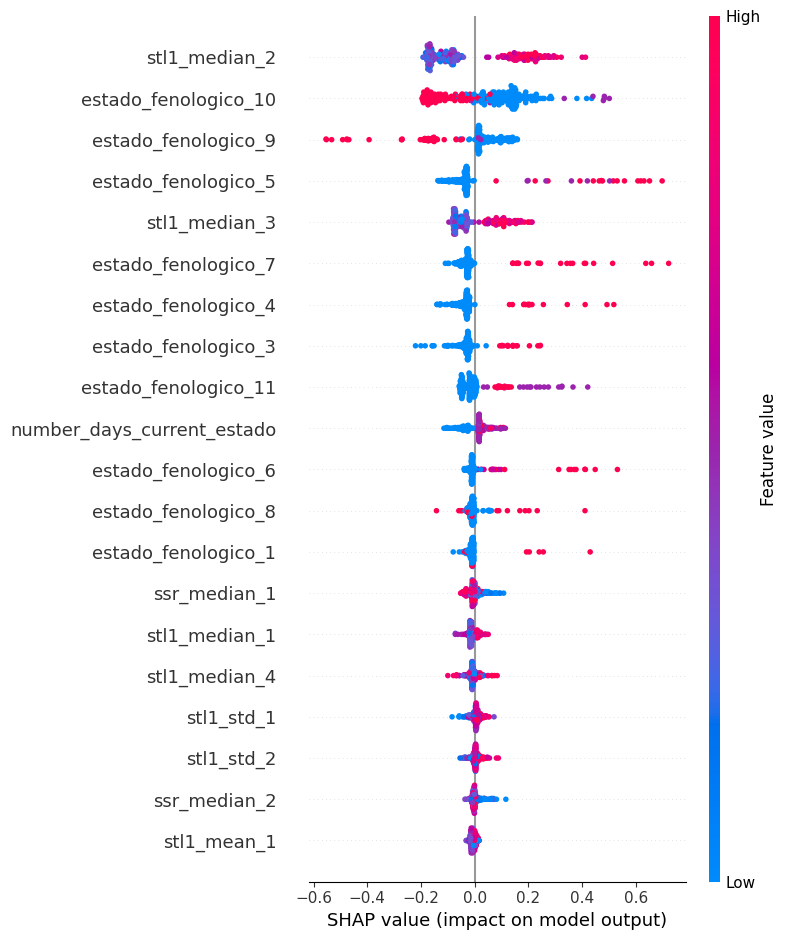

In [21]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(x_val[:250])
shap.summary_plot(shap_values, x_val[:250])

### Model just climatic Variables

In [22]:
df_only_climatic = build_dataset_with_features(categorical_features=False, binary_features=False, numeric_features=False)
df_only_climatic.dropna(subset="next_y", inplace=True)
df_only_climatic[climatic_vars] = df_only_climatic[climatic_vars].astype('float32')

train, val, test = train_test_val_split(df_only_climatic)
x_train, y_train = split_into_x_y(train)
x_test, y_test = split_into_x_y(test)
x_val, y_val = split_into_x_y(val)

In [23]:
n_trees_grid = [50]

for n_trees in n_trees_grid:
    rf = RandomForestRegressor(n_estimators=n_trees)
    rf.fit(x_train, y_train)
    get_metrics_train_val(rf,f"Random Forest Regressor Only Climatic (n_trees = {n_trees})")



Train MSE Random Forest Regressor Only Climatic (n_trees = 50): 0.02
Validation MSE Random Forest Regressor Only Climatic (n_trees = 50): 0.24
Validation MSE Discrete Random Forest Regressor Only Climatic (n_trees = 50): 0.3


### Results

In [24]:
best_models = ['Random Forest Regressor (n_trees = 50)','Random Forest All Variables Parcelas (n_trees = 50)','Random Forest Regressor Climatic (n_trees = 50)',"Random Forest Regressor Only Climatic (n_trees = 50)"]

rows = []

for name in best_models:
    metrics = metrics_dictionary[name]
    row_data = {'Model': name, 'Train MSE': metrics[0], 'Validation MSE': metrics[1], 'Discrete Validation MSE': metrics[2]}
    rows.append(row_data)

df_metrics = pd.DataFrame(rows)
df_metrics


,Model,Train MSE,Validation MSE,Discrete Validation MSE
0,Random Forest Regressor (n_trees = 50),0.13,0.28,0.34
1,Random Forest All Variables Parcelas (n_trees ...,0.06,0.27,0.32
2,Random Forest Regressor Climatic (n_trees = 50),0.02,0.24,0.30
3,Random Forest Regressor Only Climatic (n_trees...,0.02,0.24,0.30


### Test Results

In [28]:
y_pred_test = rf.predict(x_test)

y_pred_rounded = []

for pred in y_pred_test:
    if pred - int(pred) < 0.5:
        y_pred_rounded.append(max(0, math.floor(pred)))
    else:
        y_pred_rounded.append(max(0, math.ceil(pred)))

diff = y_test - y_pred_rounded
print(pd.Series(diff).value_counts())

next_y
 0.0    5682
-1.0    1364
 1.0     975
-2.0      88
 2.0      55
 3.0       2
 5.0       1
Name: count, dtype: int64


In [30]:
#Real y
print(y_test.value_counts())

next_y
0.0    4039
1.0    3170
2.0     823
3.0     129
4.0       4
5.0       1
6.0       1
Name: count, dtype: int64


In [31]:
print(mean_squared_error(y_test,y_pred_rounded))

0.3616995224684707
